# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

# slice to one month
# ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

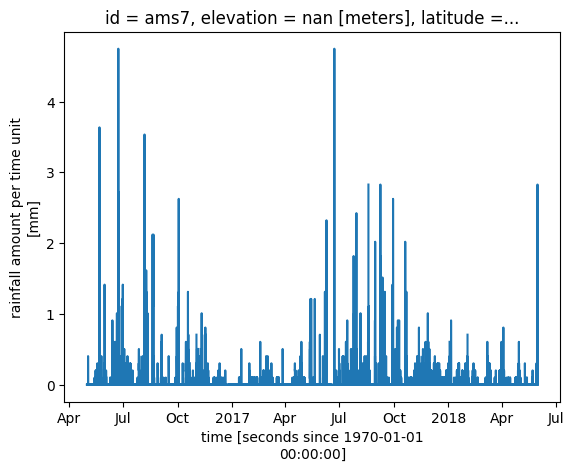

In [24]:
ds_pws.rainfall.sel(id = "ams7").plot()

In [3]:
df = pd.read_csv('SO_flags_AMSdataset.csv')
df

,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,...,-1.124,-1.125,-1.126,-1.127,-1.128,-1.129,-1.130,-1.131,-1.132,-1.133
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219162,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,-1,0,0,0,1
219163,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,-1,0,0,0,1
219164,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,-1,0,0,0,1
219165,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,-1,0,0,0,1


In [18]:
print(df.loc[:, '-1.9'])

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
219162    1
219163    1
219164    1
219165    1
219166    1
Name: -1.9, Length: 219167, dtype: int64


<Axes: >

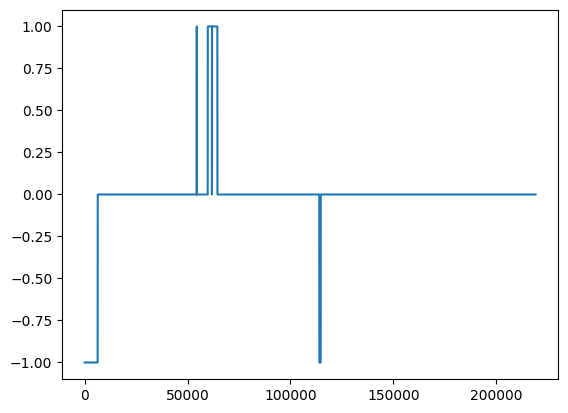

In [17]:
df['-1.6'].plot()


## Calculate distance matrix

In [25]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [26]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## SO filter (fixed evaluation period only)

In [27]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15 
beta = 0.2
n_stat = 5
max_distance = 10e3 
dbc = 1

In [28]:
# initalize data variables
ds_pws['so_flag'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws['median_corr_nbrs'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

## SO-filter - remember to discard the first mint timesteps!

In [13]:
def so_filter(da_station, da_neighbors, window_length):
    
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()

    #create dataframe of neighboring stations
    df = da_neighbors.to_dataframe()
    #drop_columns = ['elevation', 'latitude','longitude','x','y']
    #df = df.drop(drop_columns, axis = 1)
    df = df["rainfall"].unstack("id")

    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

    # number of matching rainy time steps in evaluation period
    number_of_rainy_neighbors  = (df > 0).sum(axis=1)
    rainy_timestep_at_station = s_station > 0
    matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['matches'] = xr.DataArray.from_series(matches)
    
    return ds

In [14]:
%%time

for i in [0]: # range(len(ds_pws.id)):
    
    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # if there are no observations in the time series, filter cannot be applied to the whole time series
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        print(pws_id, " has no data")
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue

    # if there are not enough stations nearby, filter cannot be applied to the whole time series
    elif (len(neighbor_ids) < n_stat):
        print(pws_id, "has less than", n_stat, "neighbors")
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue 
        
    else: 

    # run so-filter
        ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

        median_correlation = ds_so_filter.corr.median(dim='id')
        so_array = (median_correlation < gamma).astype(int)
        
    # check if enough matching rainy intervals in the rolling (fixed) evaluation period
        ds_pws.so_flag[i] = xr.where(ds_so_filter.matches < mmatch, -1, so_array)
        ds_pws.median_corr_nbrs[i] = median_correlation


CPU times: total: 19.4 s
Wall time: 19.5 s


## Bias (next step to fix)
#### rolling bias, MEDIAN not mean!

In [ ]:
# one bias correction factor per station, iteratively updated PER TIME STEP ??
BCF_prev = dbc

In [6]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 8928, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [7]:
# initialize 
ds_pws["bias"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [8]:
#bias for the whole time series with nbrs, one station
i = 0

ds_station = ds_pws.isel(id=i) 
pws_id = ds_station.id.values

neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]
ds_neighbors = ds_pws.sel(id=neighbor_ids)

s_station = ds_station.rainfall.to_series()
s_neighbors = ds_neighbors.rainfall.to_series()

roll_mean = s_neighbors.rolling(mint, min_periods=1).mean()
# rolling mean of neighbors, ie reference rainfall

# delta_r = s_station - s_neighbors
# delta_r
# delta_r = ds_station.rainfall - ds_neighbors.rainfall
# bias = np.nanmean(delta_r) / np.nanmean(ds_neighbors.rainfall)

# how to make rolling bias? 

In [52]:
reference_rainfall = ds_neighbors.rainfall.mean(dim = "id") # can be radar or other source
delta_r = ds_station.rainfall - reference_rainfall

In [59]:
bias = delta_r / reference_rainfall
bias

<xarray.DataArray 'rainfall' (time: 8928)>
array([-0.32902098,  0.213405  , -0.31635198, ...,         nan,
       -1.        ,         nan])
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
    id         <U6 'ams1'
    elevation  <U3 ...
    latitude   float64 52.31
    longitude  float64 4.671
    x          float64 2.049e+05
    y          float64 5.804e+06

In [16]:
def bias(station_rainfall, reference_rainfall):
    delta_r = station_rainfall - reference_rainfall
    return np.nanmean(delta_r) / np.nanmean(reference_rainfall)

In [ ]:
def bias_test(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    bias = np.nanmean(delta_r) / np.nanmean(reference_rainfall)
    # roll_bias = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

In [17]:
# add flags to dataset
# ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [18]:
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

In [19]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)